# Importing the required packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyomo.environ as pyo
from pyomo.dae import ContinuousSet, DerivativeVar
from pyomo.opt import SolverFactory
from pyomo.contrib.parmest import parmest # import parmest
from pyomo.contrib.parmest.experiment import Experiment
from pyomo.contrib.doe import DesignOfExperiments
import idaes

# Data

Table S1. Initial guesses for the kinetic parameter values used to test the sensitivity of MBDoE to the initial parameter
estimates (both Ramp F and Ramp FT scenarios).

## Parameter: initial guess

In [2]:
# theta_init = {
#     "Parameter Set": ["Factorial Estimates", "A", "B", "C", "D"],
#     "KP1": [9.12, 8.5, 9.5, 8.5, 9.5],
#     "KP2": [7.98, 6.0, 11, 10, 7.0],
#     "k0 (s^-1)": ["1.17E+07", "3.95E+04", "1.17E+11", "1.32E+10", "3.49E+05"],
#     "EA (J/mol)": [79800, 60000, 110000, 100000, 70000],
#     "k at 100°C (*10^5 s^-1)": [0.78, 1.58, 0.47, 1.33, 0.56],
#     "k at 120°C (*10^5 s^-1)": [2.88, 4.21, 2.84, 6.85, 1.75],
#     "k at 140°C (*10^5 s^-1)": [9.40, 10.25, 14.50, 30.11, 4.94]
# }

# theta_init = pd.DataFrame(theta_init)
# theta_init.columns = ['Parameter Set', 'KP1', 'KP2', 'k0', 'EA',
#        'k@100C', 'k@120C', 'k@140C']
# theta_init


## Flowrate ramp at 119C and $C_F$ = 1.56M

Table S2. Time each sample was measured, left and entered the reactor and corresponding reaction time,
along with conversion and outlet concentrations of benzoic acid and ethyl benzoate for the first MBDoE Ramp
F experiment. The initial flowrate was 29.8 µL/min, the flowrate was ramped down at a rate of 0.253 µL/min2
, while the temperature was held constant at 119 oC and the feed concentration was 1.56 M.

In [3]:
data_FR1 = {
    "tM,i Time the sample was measured (s)": [408, 828, 1248, 1667, 2084, 2504, 2923, 3342, 3763, 4182, 4603, 5024, 5444, 5864],
    "tIn,i Time the sample entered the reactor (s)": [110, 511, 910, 1304, 1693, 2080, 2460, 2833, 3198, 3549, 3885, 4199, 4481, 4722],
    "tL,i Time the sample left the reactor (s)": [314, 728, 1141, 1552, 1959, 2368, 2774, 3177, 3578, 3972, 4360, 4736, 5094, 5422],
    "τi Sample reaction time (s)": [204, 217, 231, 248, 267, 288, 314, 344, 380, 422, 474, 537, 613, 700],
    "X Conversion (%)": [5.8, 5.8, 6.4, 7.1, 7.1, 7.7, 8.3, 9.0, 9.6, 10.9, 12.2, 13.5, 14.7, 16.7],
    "Outlet Concentration Benzoic Acid (M)": [1.47, 1.47, 1.46, 1.45, 1.45, 1.44, 1.43, 1.42, 1.41, 1.39, 1.37, 1.35, 1.33, 1.30],
    "Outlet Concentration Ethyl Benzoate (M)": [0.09, 0.09, 0.10, 0.10, 0.11, 0.12, 0.13, 0.14, 0.15, 0.17, 0.18, 0.20, 0.23, 0.25]
}

ramp_F1 = pd.DataFrame(data_FR1)
ramp_F1.columns = columns=["t_m (s)", "t_in (s)", "t_L (s)", "tau_(s)", "X(%)", "C_BA(M)", "C_EB(M)"]
# adding the temperature to the data
ramp_F1["T(C)"] = 119
# adding the feed concentration to the data
ramp_F1["C_F(M)"] = 1.56

# adding the ramped flowrate to the data
initial_flowrate = 29.8  # µL/min
ramp_rate = 0.253  # µL/min^2

# Calculate the time elapsed since the start of the ramp
time_elapsed = ramp_F1['t_m (s)']

# Calculate the flowrate at each time point
ramp_F1['F(µL/min)'] = initial_flowrate - (ramp_rate * time_elapsed / 60)
ramp_F1

,t_m (s),t_in (s),t_L (s),tau_(s),X(%),C_BA(M),C_EB(M),T(C),C_F(M),F(µL/min)
0,408,110,314,204,5.8,1.47,0.09,119,1.56,28.079600
1,828,511,728,217,5.8,1.47,0.09,119,1.56,26.308600
2,1248,910,1141,231,6.4,1.46,0.10,119,1.56,24.537600
3,1667,1304,1552,248,7.1,1.45,0.10,119,1.56,22.770817
4,2084,1693,1959,267,7.1,1.45,0.11,119,1.56,21.012467
5,2504,2080,2368,288,7.7,1.44,0.12,119,1.56,19.241467
6,2923,2460,2774,314,8.3,1.43,0.13,119,1.56,17.474683
7,3342,2833,3177,344,9.0,1.42,0.14,119,1.56,15.707900
8,3763,3198,3578,380,9.6,1.41,0.15,119,1.56,13.932683
9,4182,3549,3972,422,10.9,1.39,0.17,119,1.56,12.165900


In [4]:
# # Plotting the data
# fig, ax = plt.subplots(figsize=(10, 6))
# # plotting on left y-axis
# ax.plot(ramp_F1["t_m (s)"], ramp_F1["T(C)"], "-k", label="Temperature($^oC$)")
# ax.plot(ramp_F1["t_m (s)"], ramp_F1["F(µL/min)"], "-.c", label="Flowrate(µL/min)")
# ax.set_xlabel('Time (min)')
# ax.set_ylabel('Temperature (°C), Flowrate (µL/min)')
# ax.tick_params('y', colors='k')
# ax.set_ylim(0, 160)

# # plotting on right y-axis
# ax2 = ax.twinx()
# ax2.plot(ramp_F1["t_m (s)"], ramp_F1["C_F(M)"], "^r", label="Feed Concentration(M)")
# ax2.plot(ramp_F1["t_m (s)"], ramp_F1["C_BA(M)"], "og", label=r"$C_{BA}$(M)")
# ax2.plot(ramp_F1["t_m (s)"], ramp_F1["C_EB(M)"], "sb", label=r"$C_{EB}$(M)")
# ax2.set_ylabel('Concentration (M)')
# ax2.tick_params('y', colors='k')
# ax2.set_ylim(0, 1.6)

# # Customize the plot
# plt.title('Flowrate ramp at 119°C and 1.56 M feed concentration')
# fig.tight_layout()

# # Combine legends from both axes
# lines, labels = ax.get_legend_handles_labels()
# lines2, labels2 = ax2.get_legend_handles_labels()
# ax2.legend(lines + lines2, labels + labels2)

## Flowrate ramp at 139.4C and $C_F$ = 1.55 M

Table S3. Time each sample was measured, left and entered the reactor and corresponding reaction time,
along with conversion and outlet concentrations of benzoic acid and ethyl benzoate for the second MBDoE
Ramp F experiment. The initial flowrate was 9.13 µL/min, the flowrate was ramped down at a rate of 0.043
µL/min2, while the temperature was held constant at 139.4 oC and the feed concentration was 1.55 M.

In [5]:
# data_FR2 = {
#     "Time the sample was measured (t_M,i)": [152, 571, 991, 1411, 1830, 2251, 2670, 3090, 3510, 3931, 4350, 4770, 5190, 5610],
#     "Time the sample entered the reactor (t_In,i)": [None, None, 17, 404, 787, 1170, 1549, 1925, 2298, 2668, 3033, 3393, 3749, 4098],
#     "Time the sample left the reactor (t_L,i)": [None, 271, 680, 1089, 1496, 1904, 2309, 2714, 3117, 3520, 3920, 4318, 4715, 5109],
#     "Sample reaction time (τ_i)": [623, 643, 663, 685, 709, 734, 760, 789, 819, 852, 887, 925, 966, 1010],
#     "Conversion (X)": [44.9, 45.5, 46.2, 47.4, 48.1, 48.7, 50.0, 51.3, 51.9, 53.8, 55.1, 56.4, 57.7, 59.0],
#     "Outlet Concentration Benzoic Acid (M)": [0.86, 0.85, 0.84, 0.82, 0.81, 0.80, 0.78, 0.76, 0.75, 0.72, 0.70, 0.68, 0.66, 0.64],
#     "Outlet Concentration Ethyl Benzoate (M)": [0.70, 0.70, 0.72, 0.73, 0.74, 0.76, 0.78, 0.79, 0.81, 0.83, 0.86, 0.87, 0.90, 0.92]
# }

# ramp_F2 = pd.DataFrame(data_FR2)
# ramp_F2.columns = columns=["t_m (s)", "t_in (s)", "t_L (s)", "tau_(s)", "X(%)", "C_BA(M)", "C_EB(M)"]
# # adding the temperature to the data
# ramp_F2["T(C)"] = 139.4 #oC
# # adding the feed concentration to the data
# ramp_F2["C_F(M)"] = 1.55  # M

# # adding the ramped flowrate to the data
# initial_flowrate = 9.13  # µL/min
# ramp_rate = 0.043  # µL/min

# # Calculate the time elapsed since the start of the ramp
# time_elapsed = ramp_F2['t_m (s)']

# # Calculate the flowrate at each time point
# ramp_F2['F(µL/min)'] = initial_flowrate - (ramp_rate * time_elapsed / 60)
# ramp_F2
# ramp_F2


In [6]:
# # Plotting the data
# fig, ax = plt.subplots(figsize=(10, 6))
# # plotting on left y-axis
# ax.plot(ramp_F2["t_m (s)"], ramp_F2["T(C)"], "-k", label="Temperature($^oC$)")
# ax.plot(ramp_F2["t_m (s)"], ramp_F2["F(µL/min)"], "-.c", label="Flowrate(µL/min)")
# ax.set_xlabel('Time (min)')
# ax.set_ylabel('Temperature (°C), Flowrate (µL/min)')
# ax.tick_params('y', colors='k')
# ax.set_ylim(0, 160)

# # plotting on right y-axis
# ax2 = ax.twinx()
# ax2.plot(ramp_F2["t_m (s)"], ramp_F2["C_F(M)"], "^r", label="Feed Concentration(M)")
# ax2.plot(ramp_F2["t_m (s)"], ramp_F2["C_BA(M)"], "og", label=r"$C_{BA}$(M)")
# ax2.plot(ramp_F2["t_m (s)"], ramp_F2["C_EB(M)"], "sb", label=r"$C_{EB}$(M)")
# ax2.set_ylabel('Concentration (M)')
# ax2.tick_params('y', colors='k')
# ax2.set_ylim(0, 1.6)

# # Customize the plot
# plt.title('Flowrate ramp at 139.4°C and 1.55 M feed concentration')
# fig.tight_layout()

# # Combine legends from both axes
# lines, labels = ax.get_legend_handles_labels()
# lines2, labels2 = ax2.get_legend_handles_labels()
# ax2.legend(lines + lines2, labels + labels2)

## Flowrate and Temperature ramp

Table S4. Time each sample was measured, left and entered the reactor, corresponding reaction time, and the
reactor temperature at the time the samples entered and left the reactor, along with conversion and outlet
concentrations of benzoic acid and ethyl benzoate for the MBDoE Ramp FT experiment. The initial flowrate
was 10.1 µL/min, the flowrate was ramped down at a rate of 0.05 µL/min2
, while the initial temperature was
139.2 °C, and it was ramped down at a rate of 0.537 °C/min. The feed concentration of benzoic acid was held
constant at 1.56 M.

In [7]:
# data_FT = {
#     "Time the sample was measured (s)": [419, 840, 1260, 1679, 2099, 2519, 2939, 3359, 3779, 4199, 4619, 5038, 5457, 5876],
#     "Time the sample entered the reactor (s)": ["NA", "NA", 354, 739, 1124, 1505, 1883, 2258, 2629, 2996, 3358, 3714, 4064, 4407],
#     "Time the sample left the reactor (s)": ["NA", 150, 561, 971, 1379, 1786, 2193, 2599, 3003, 3406, 3807, 4206, 4602, 4995],
#     "Sample reaction time (s)": [577, 596, 617, 639, 663, 688, 716, 745, 777, 811, 848, 888, 931, 979],
#     "Reactor temperature at time tini (°C)": [139.2, 139.2, 136.0, 132.6, 129.1, 125.7, 122.3, 119.0, 115.7, 112.4, 109.1, 106.0, 102.8, 99.8],
#     "Reactor temperature at time tLi (°C)": [139.2, 134.2, 130.5, 126.9, 123.2, 119.6, 115.9, 112.3, 108.7, 105.1, 101.6, 98.0, 94.5, 91.0],
#     "X Conversion (%)": [41.5, 39.6, 35.1, 31.2, 26.7, 23.5, 19.7, 17.1, 14.5, 12.6, 10.0, 8.7, 7.5, 6.2],
#     "Outlet Conc. Benzoic Acid (M)": [0.91, 0.94, 1.01, 1.07, 1.14, 1.19, 1.25, 1.29, 1.33, 1.36, 1.40, 1.42, 1.44, 1.46],
#     "Outlet Conc. Ethyl Benzoate (M)": [0.64, 0.62, 0.55, 0.49, 0.42, 0.37, 0.31, 0.27, 0.22, 0.19, 0.16, 0.13, 0.11, 0.09]
# }

# ramp_FT = pd.DataFrame(data_FR2)
# ramp_FT.columns = columns=["t_m (s)", "t_in (s)", "t_L (s)", "tau_(s)", "X(%)", "C_BA(M)", "C_EB(M)"]

# # adding the temperature to the data
# T_ramp_rate = 0.537 # °C/min
# time_elapsed = ramp_FT['t_m (s)']
# ramp_FT["T(C)"] = 139.2 - (T_ramp_rate * time_elapsed / 60)

# # adding the feed concentration to the data
# ramp_FT["C_F(M)"] = 1.56  # M

# # adding the ramped flowrate to the data
# initial_flowrate = 29.8  # µL/min
# ramp_rate = 0.253  # µL/min^2

# # Calculate the flowrate at each time point
# ramp_FT['F(µL/min)'] = initial_flowrate - (ramp_rate * time_elapsed / 60)
# ramp_FT

In [8]:
# # Plotting the data
# fig, ax = plt.subplots(figsize=(10, 6))
# # plotting on left y-axis
# ax.plot(ramp_FT["t_m (s)"], ramp_FT["T(C)"], "-k", label="Temperature($^oC$)")
# ax.plot(ramp_FT["t_m (s)"], ramp_FT["F(µL/min)"], "-.c", label="Flowrate(µL/min)")
# ax.set_xlabel('Time (min)')
# ax.set_ylabel('Temperature (°C), Flowrate (µL/min)')
# ax.tick_params('y', colors='k')
# ax.set_ylim(0, 160)

# # plotting on right y-axis
# ax2 = ax.twinx()
# ax2.plot(ramp_FT["t_m (s)"], ramp_FT["C_F(M)"], "^r", label="Feed Concentration(M)")
# ax2.plot(ramp_FT["t_m (s)"], ramp_FT["C_BA(M)"], "og", label=r"$C_{BA}$(M)")
# ax2.plot(ramp_FT["t_m (s)"], ramp_FT["C_EB(M)"], "sb", label=r"$C_{EB}$(M)")
# ax2.set_ylabel('Concentration (M)')
# ax2.tick_params('y', colors='k')
# ax2.set_ylim(0, 1.6)

# # Customize the plot
# plt.title('Flowrate ramp at 139.4°C and 1.55 M feed concentration')
# fig.tight_layout()

# # Combine legends from both axes
# lines, labels = ax.get_legend_handles_labels()
# lines2, labels2 = ax2.get_legend_handles_labels()
# ax2.legend(lines + lines2, labels + labels2)

# Model

$\qquad \nu \rightarrow$ volumetric flow rate, $\mu L/min\\$
$\qquad C_{BA} \rightarrow$ concentration of benzoic acid, $M\\$
$\qquad z \rightarrow$ distance from the entrance of the reactor, $ \mu m$


1. Material Balance for a Plug Flow Reactor (PFR)

$$
\frac{\partial C_{BA}}{\partial t} + u \frac{\partial C_{BA}}{\partial z} = r_{BA}
$$

2. Substituting $u = \frac{\nu(t)}{u}$

$$
\frac{\partial C_{BA}}{\partial t} + \frac{\nu(t)}{A_c} \frac{\partial C_{BA}}{\partial z} = r_{BA}
$$

3. Expression for the Ramped Flowrate

$$
\nu(t) = \nu_0 + \alpha_\nu t
$$

4. Boundary Condition at the Reactor Inlet (z=0)

$$
C_{BA}(t, z = 0) = C_{A0}
$$

5. Initial Condition 

$$
C_{BA}(t =0, z > 0) = 0
$$



# Class  / Model

In [ ]:
# SOLVING THE MODEL USING IPOPT
def BA_kinetics(data):
    m = pyo.ConcreteModel()

    # Conversion factors
    m.sec2min = 1 / 60  # seconds to minutes

    # Define sets
    m.t = ContinuousSet(bounds=(0, 3.4))  # reaction time in minutes
    m.z = ContinuousSet(bounds=(0, 20))  # length of the reactor: 20 dm

    # Define variables
    m.C_BA = pyo.Var(m.t, m.z, initialize=1.56)  # benzoic acid concentration in M
    m.T = pyo.Var(m.t, initialize=119)  # temperature in °C
    m.T.fix(119)  # fix the temperature
    m.v = pyo.Var(m.t, initialize=29.8e-6, domain=pyo.NonNegativeReals)  # flowrate in L/min

    # Define derivative variables
    m.dC_BA_dt = DerivativeVar(m.C_BA, wrt=m.t)
    m.dC_BA_dz = DerivativeVar(m.C_BA, wrt=m.z)

    # Define parameters
    m.k =  pyo.Param(initialize = (10e-5 / m.sec2min))  # bounds=(0, 2) reaction rate constant, min^-1
    m.KP1 = pyo.Param(initialize=9.17)  # dimensionless
    m.KP2 = pyo.Param(initialize=8.18)  # J/mol

    # TODO: replace this hyperparameters with `initial_values` in the `__init__` constructor
    # hyperparameters
    m.alpha_T = 0  # Temperature ramp, °C/min
    m.alpha_v = 0.253e-6  # flowrate ramp, L/min^2
    m.v0 = 29.8e-6  # initial flowrate, L/min
    m.T0 = 119 + 273.15 # initial temperature, K
    m.C_BA0 = 1.56  # initial benzoic acid concentration, M

    # Constants
    m.d = 250e-5  # diameter of the reactor, dm (decimeters)
    m.Ac = np.pi * (m.d / 2) ** 2  # Reactor cross-sectional area, dm^2
    m.R = 8.314462618  # Universal gas constant, J/(mol-K)
    m.Tm = 378.15  # average temperature of the reactor, K

    # Expressions
    # equation for k0
    m.k0 = pyo.Expression(expr=pyo.exp(-m.KP1 + m.KP2 * 10000 / (m.R * m.Tm)))

    # equation for EA
    m.EA = pyo.Expression(expr=m.KP2 * 10000)


    # Define the differential equations
    @m.Constraint(m.t, m.z)
    def _pde_eqn(m, t, z):
        return (
                m.dC_BA_dt[t, z] == -m.v[t] * m.dC_BA_dz[t, z] - m.k * m.C_BA[t, z]
            )  # PDE of the concentration of BA

    # ramping the flowrate
    @m.Constraint(m.t)
    def flowrate_ramp(m, t):
        return m.v[t] == m.v0 - m.alpha_v * t   # L/min

    # TODO: uncomment this section to ramp the temperature
    # # ramping the temperature
    # @m.Constraint(m.t)
    # def temperature_ramp(m, t):
    #     return m.T[t] == m.T0 - m.alpha_T * t

    # # Boundary and initial conditions
    # @m.Constraint(m.t)
    # def C_BA_at_t0_and_z(m, t):
    #     return m.C_BA[t, 0] == m.C_BA0 # (m.C_BA0 if z==0 else 0)  # initial condition: C_BA(t=0, z) = C_BA0
    #     # if z == 0:
    #     #     return m.C_BA[t, 0] == m.C_BA0  # Boundary condition: C_BA(t, z=0) = C_BA0
    #     # elif z > 0:
    #     #     return m.C_BA[0, z] == 0  # initial condition: C_BA(t=0, z>0) = 0

    # # boundary condition
    m.C_BA[0, 0].fix(m.C_BA0)
    # m.C_BA[0, :].fix(0)

    # Discretize the model using finite difference
    pyo.TransformationFactory("dae.finite_difference").apply_to(m, nfe=30, wrt=m.t)  # discretize wrt time
    pyo.TransformationFactory("dae.finite_difference").apply_to(m, nfe=30, wrt=m.z)  # discretize wrt length

    # Print the number of constraints and variables
    print(f"Number of constraints: {len(m.component_map(pyo.Constraint))}")
    print(f"Number of variables: {len(m.component_map(pyo.Var))}")


    # Solve the model
    solver = SolverFactory("ipopt")
    solver.options["linear_solver"] = "MA57"
    solver.options["max_iter"] = 500
    res = solver.solve(m, tee=True)

    return res, m  # return the results and the model

In [23]:
res, model = BA_kinetics(ramp_F1)
# # extract the concentration at the exit of the reactor


Number of constraints: 4
Number of variables: 5
Ipopt 3.13.2: linear_solver=MA57
max_iter=500


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collect

In [25]:
C_BA = [pyo.value(model.C_BA[t, 20]) for t in model.t]
C_BA

[1.575705795548199,
 1.574635047200644,
 1.573565017029527,
 1.5724957234167645,
 1.5714271564268678,
 1.570359306150321,
 1.5692921909315927,
 1.568225800855435,
 1.56716012603252,
 1.5660951847699445,
 1.56503096717266,
 1.5639674633714855,
 1.562904691636222,
 1.5618426420919795,
 1.5607813048896828,
 1.559720698261913,
 1.5586608123538979,
 1.5576016373366268,
 1.556543191405537,
 1.5554854647259329,
 1.5544284474888272,
 1.5533721578525896,
 1.5523165860025592,
 1.5512617221497327,
 1.5502075844154863,
 1.5491541630051544,
 1.5481014481496758,
 1.5470494579335095,
 1.5459981825819435,
 1.5449476123458188,
 1.5438977652727521]

In [18]:
list(model.z)

[0,
 0.666667,
 1.333333,
 2.0,
 2.666667,
 3.333333,
 4.0,
 4.666667,
 5.333333,
 6.0,
 6.666667,
 7.333333,
 8.0,
 8.666667,
 9.333333,
 10.0,
 10.666667,
 11.333333,
 12.0,
 12.666667,
 13.333333,
 14.0,
 14.666667,
 15.333333,
 16.0,
 16.666667,
 17.333333,
 18.0,
 18.666667,
 19.333333,
 20]

In [13]:
# def BA_kinetics(data):
#     m = pyo.ConcreteModel()

#     # Define sets
#     m.t = ContinuousSet(bounds=(0, 6000), initialize=data["t_m (s)"])
#     m.z = ContinuousSet(bounds=(0, 2))  # length of the reactor: 2m

#     # Define variables
#     m.C_BA = pyo.Var(m.t, m.z, initialize=1.56)  # benzoic acid concentration in M
#     m.T = pyo.Var(m.t, initialize=119)  # temperature in °C
#     m.v = pyo.Var(m.t, initialize=29.8e-6 )  # flowrate in µL/min

#     # Define derivative variables
#     m.dC_BA_dt = DerivativeVar(m.C_BA, wrt=m.t)
#     m.dC_BA_dz = DerivativeVar(m.C_BA, wrt=m.z)

#     # Define parameters
#     m.k = pyo.Var(bounds = (0, 2))  # reaction rate constant, s^-1
#     m.KP1 = pyo.Var(bounds = (0, 10))  # dimensionless
#     m.KP2 = pyo.Var(bounds = (0, 10))  # J/mol

#     # TODO: replace this hyperparameters with `initial_values` in the `__init__` constructor
#     # hyperparameters
#     m.alpha_T = 0 # Temperature ramp, °C/min
#     m.alpha_v = 0.253 # flowrate ramp, µL/min^2
#     m.v0 = 29.8e-6  # initial flowrate, µL/min
#     m.T0 = 119  # initial temperature, °C
#     m.C_BA0 = 1.56  # initial benzoic acid concentration, M

#     # Constants
#     m.d = 250e-6  # diameter of the reactor, m
#     m.Ac = np.pi * ( m.d / 2)**2 # Reactor cross-sectional area, m^2
#     m.R = 8.314462618  # Universal gas constant, J/(mol-K)
#     m.Tm = 378.15  # average temperature of the reactor, K

#     # Expressions
#     # equation for k0
#     m.k0 = pyo.Expression(expr=pyo.exp(-m.KP1 + m.KP2 * 10000 / (m.R * m.Tm)))

#     # equation for EA
#     m.EA = pyo.Expression(expr=m.KP2 * 10000)

#     # Constraints
#     # Define the Arrhenius equation
#     @m.Constraint(m.t)  # this is indexed by time, b/c the temperature is changing with time when `T` is ramped
#     def k_eqn(m, t):
#         return m.k == pyo.exp(-m.KP1 - (m.KP2 * 10000 / m.R) * (1 / m.T[t] - 1 / m.Tm))

#     # Define the differential equations
#     @m.Constraint(m.t, m.z)
#     def pde_eqn(m, t, z):
#         if z == 0:
#             return pyo.Constraint.Skip
#         else:
#             return m.dC_BA_dt[t, z] == - m.v[t] * m.dC_BA_dz[t, z] - m.k * m.C_BA[t, z]  # PDE of the concentration of BA

#     # ramping the flowrate
#     @m.Constraint(m.t)
#     def flowrate_ramp(m, t):
#         return m.v[t] == m.v0 - m.alpha_v * t

#     # ramping the temperature
#     @m.Constraint(m.t)
#     def temperature_ramp(m, t):
#         return m.T[t] == m.T0 -  m.alpha_T * t

#     # Boundary and initial conditions
#     @m.Constraint(m.t, m.z)
#     def C_BA_at_t0_and_z(m, t, z): 
#         if z == 0:
#             return m.C_BA[t, 0] == m.C_BA0  # Boundary condition: C_BA(t, z=0) = C_BA0
#         else:  
#             return m.C_BA[0, z] == 0  # initial condition: C_BA(t=0, z>0) = 0 

#     # # boundary condition
#     # m.C_BA[0, 0].fix(m.C_BA0)
#     # m.C_BA[0, :].fix(0)

#     # Discretize the model using finite difference
#     pyo.TransformationFactory('dae.finite_difference').apply_to(m, nfe=30, wrt= m.t)  # discretize wrt time
#     pyo.TransformationFactory("dae.finite_difference").apply_to(m, nfe=30, wrt=m.z)  # discretize wrt length

#     # Solve the model
#     solver = SolverFactory('ipopt')
#     res = solver.solve(m, tee=True)

#     return res, m   # return the results and the model

Text(0, 0.5, 'Concentration of Benzoic Acid (M) at z = 2')

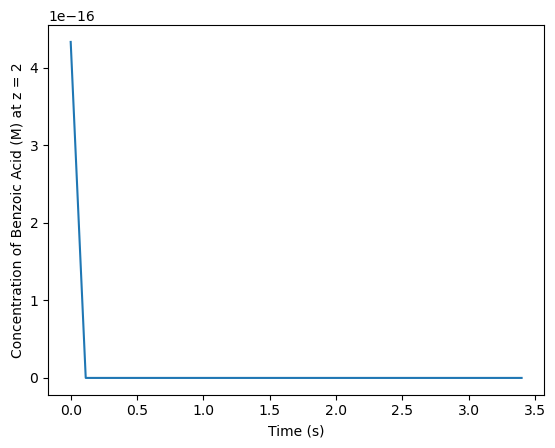

In [14]:
time = list(model.t)
plt.plot(time, C_BA)
plt.xlabel('Time (s)')
plt.ylabel('Concentration of Benzoic Acid (M) at z = 2')

In [15]:
# class KineticModel(Experiment):
#     def __init__(self, data, theta_initial = None):
#         self.data = data
#         self.theta_initial = theta_initial
        
            


        

In [16]:
# time required to pass through the reactor
2 * np.pi * (250e-6/2)**2 / (29.8e-6 * 1e-3 / 60)

197.66732300271352